## Run experiment Atlantic_gates

In [29]:
import lagrangian as lg
import numpy as np
import time

project = 'GLORYS12_ORCA'
#project = 'NEMO'
case = 'AW_60N'
case = 'Atlantic_gates_Lom_hf'
#case = 'Nordic11'
years = [1995]
print(years)


for year in years:
    if '1year' in case or 'Lom' in case:
        print('Adjusting loop year...')
        year_loop = [year,year]
    else:
        year_loop = None
        
    start_date = str(year)+'-01-01'
    print(start_date)
    lg.namelist(project,case,start_date,n_seed = 12,n_step = 60*12,oname='output',year_loop=year_loop)
    lg.runtracmass(project,case,rname=start_date)
    time.sleep(40)


[1995]
Adjusting loop year...
1995-01-01
Started run on tmux session  tracmass_GLORYS12_ORCA_Atlantic_gates_Lom_hf_1995-01-01


KeyboardInterrupt: 

## Compare fram strait, Barents Sea overturning

read
Data has  12  seeding time steps
['out', 'inside', 'err', 'barents_out', 'fram_out']
--- Doing out
823 / 7269 particles
0.1 Sv / 0.4 Sv
--- Doing inside
2703 / 7269 particles
0.3 Sv / 0.4 Sv
need at least one array to concatenate
--- Doing err
42 / 7269 particles
0.0 Sv / 0.4 Sv
need at least one array to concatenate
--- Doing barents_out
562 / 7269 particles
0.1 Sv / 0.4 Sv
--- Doing fram_out
261 / 7269 particles
0.0 Sv / 0.4 Sv


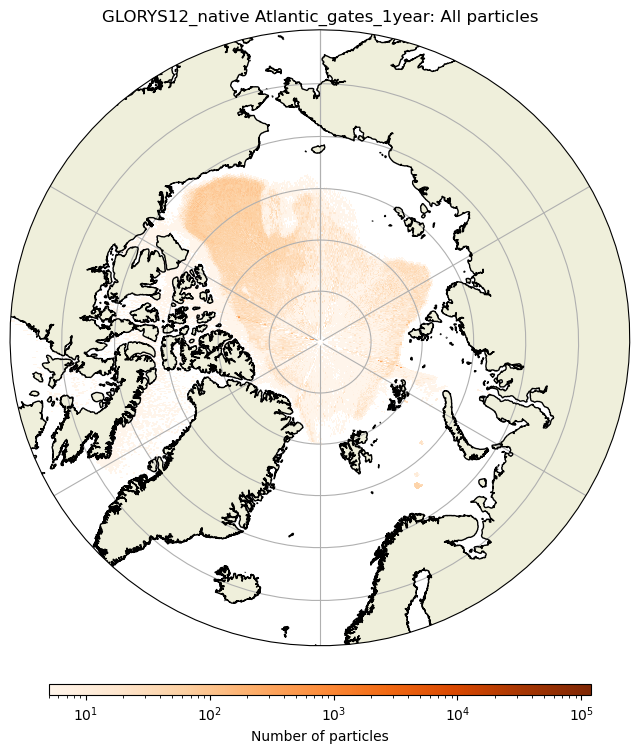

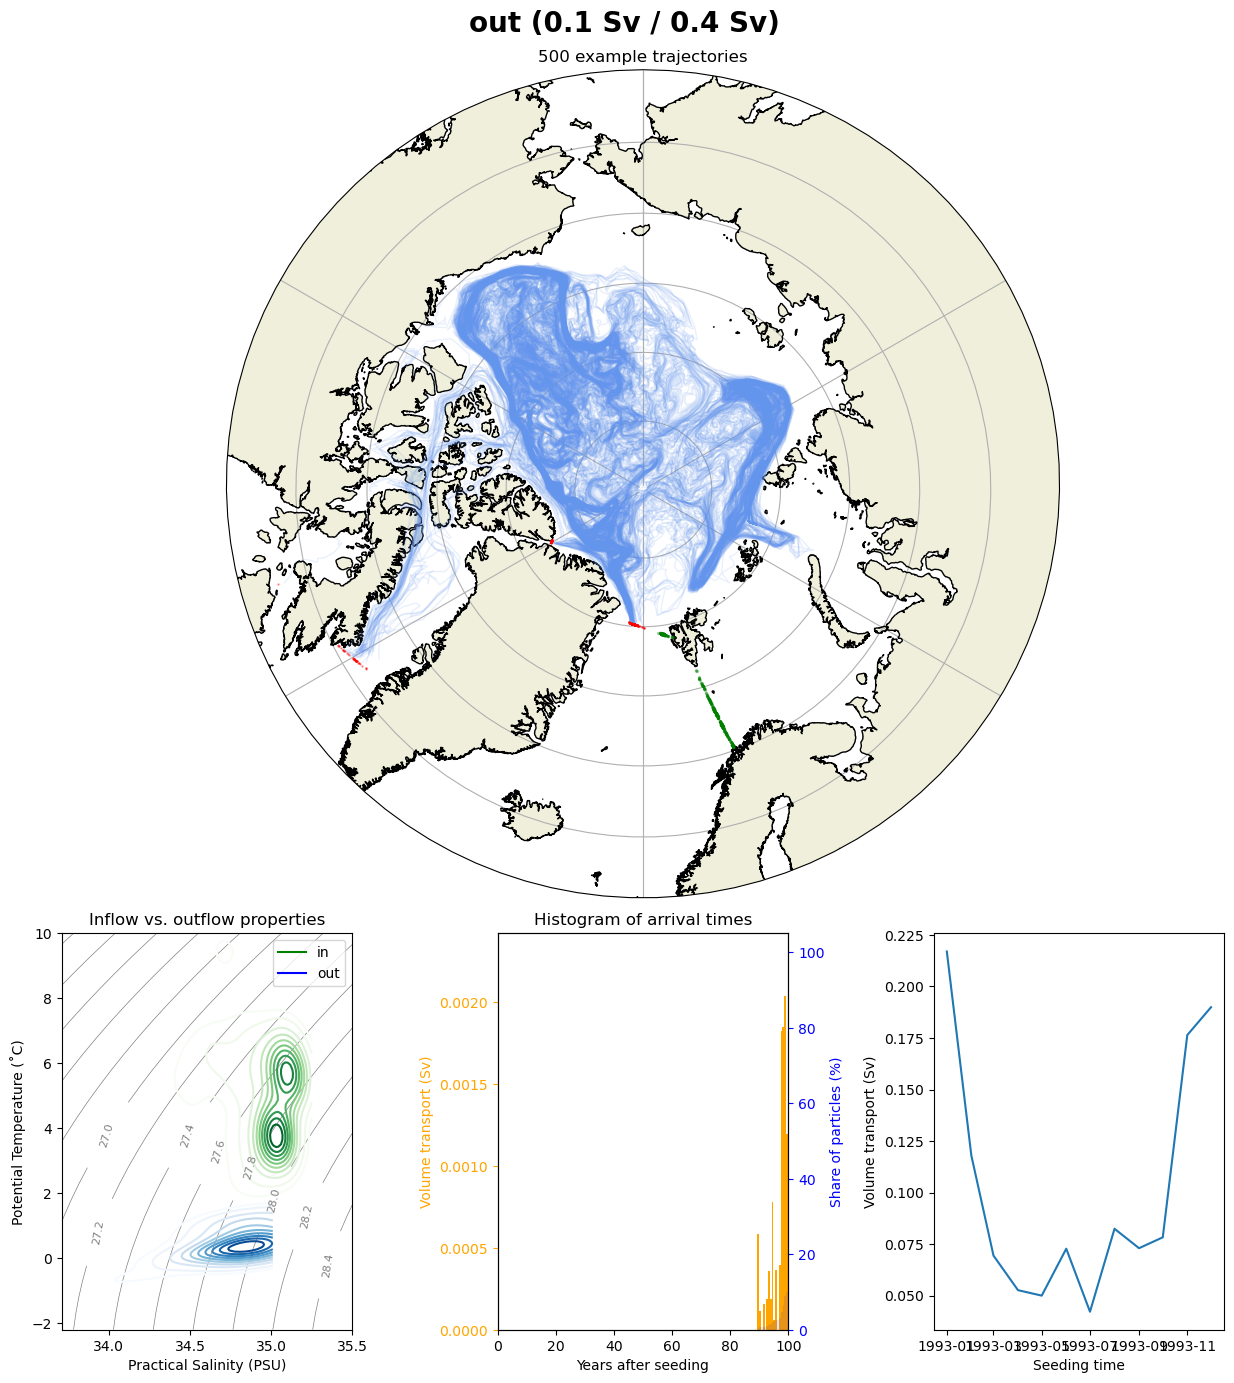

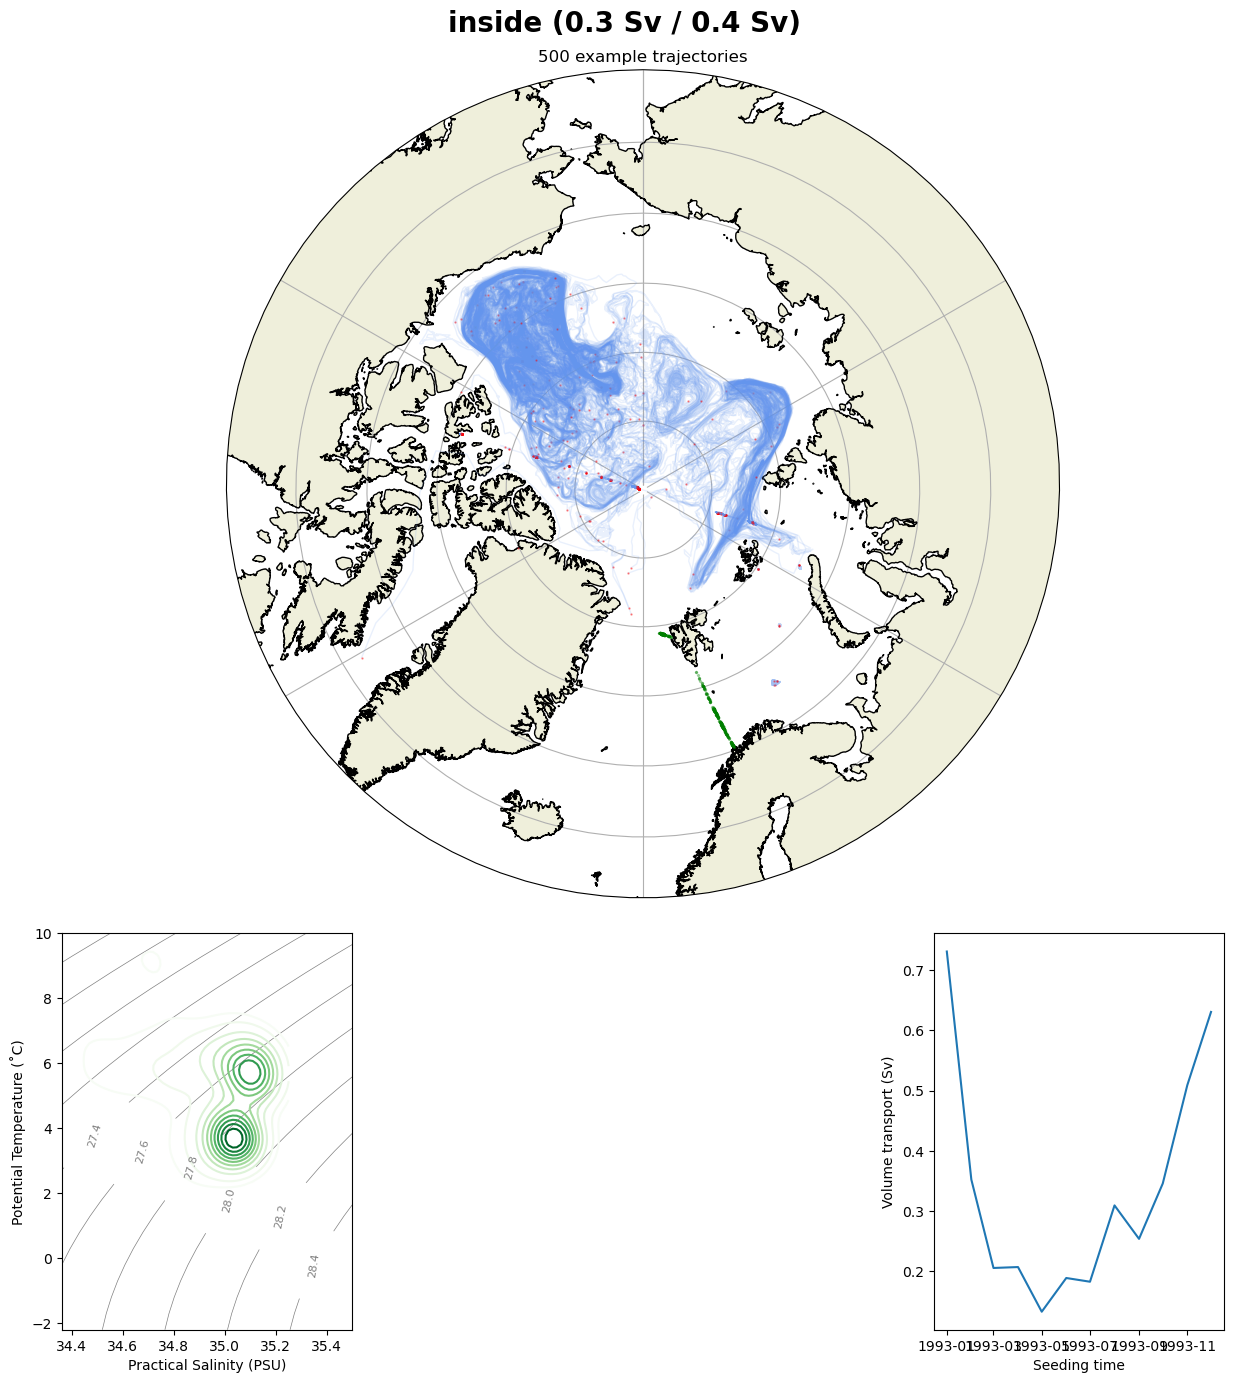

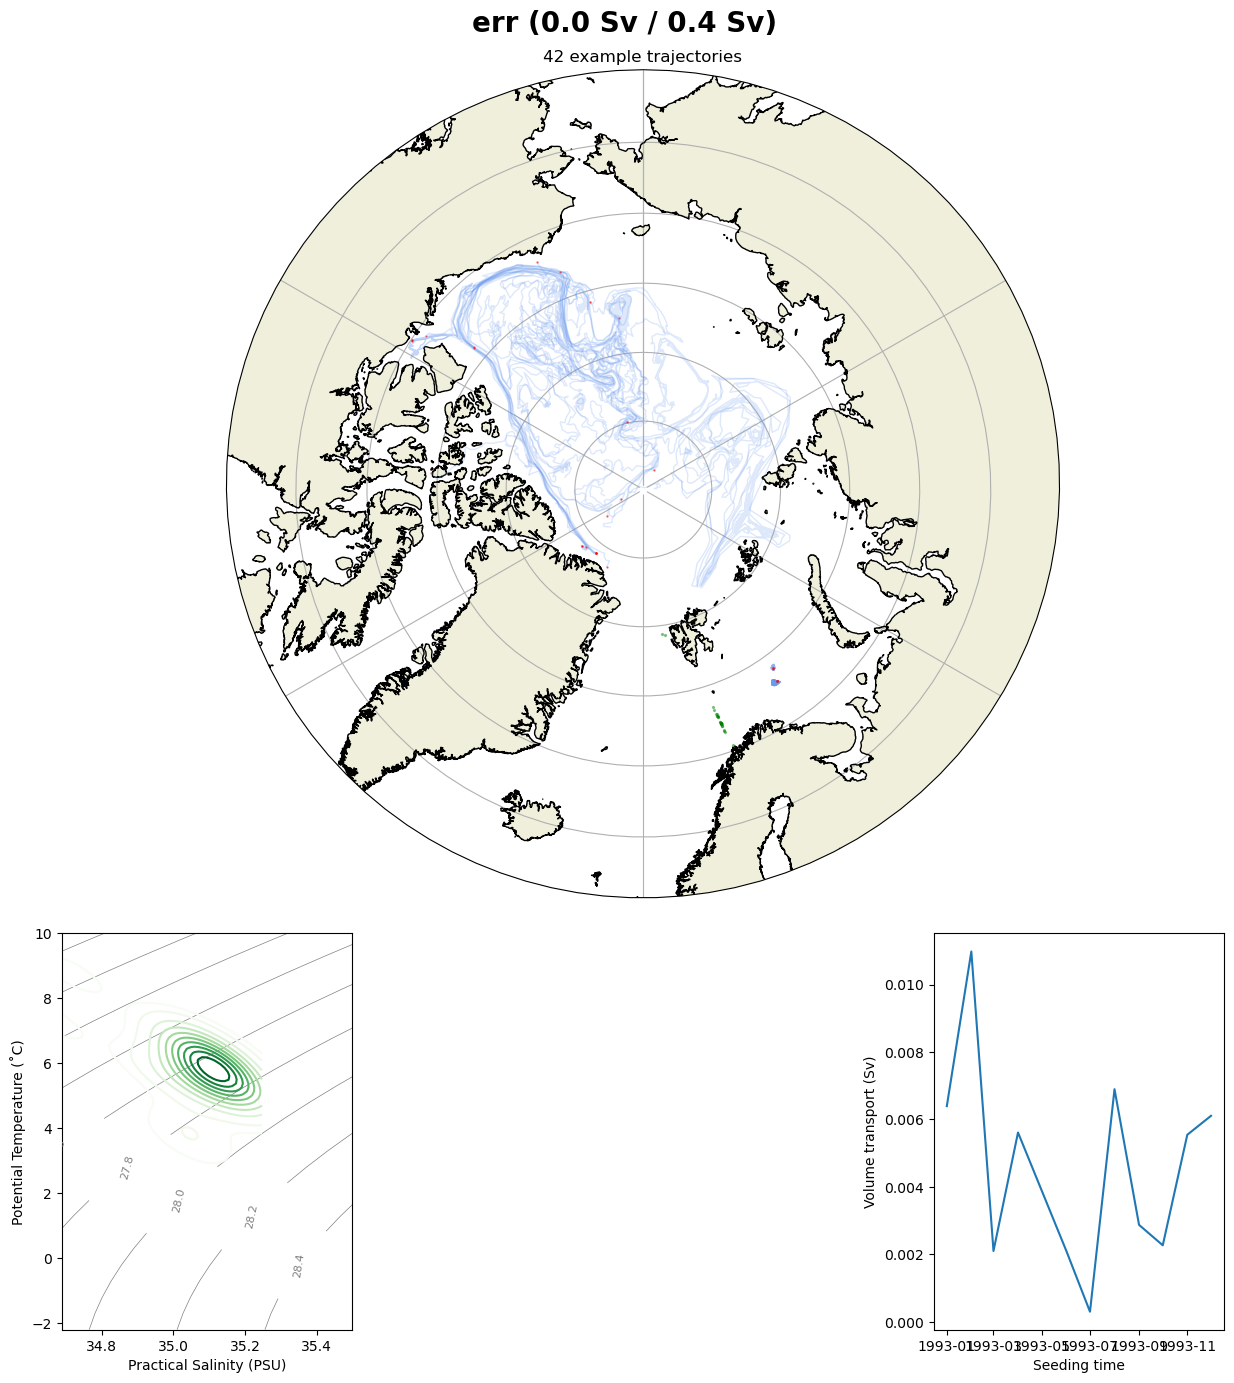

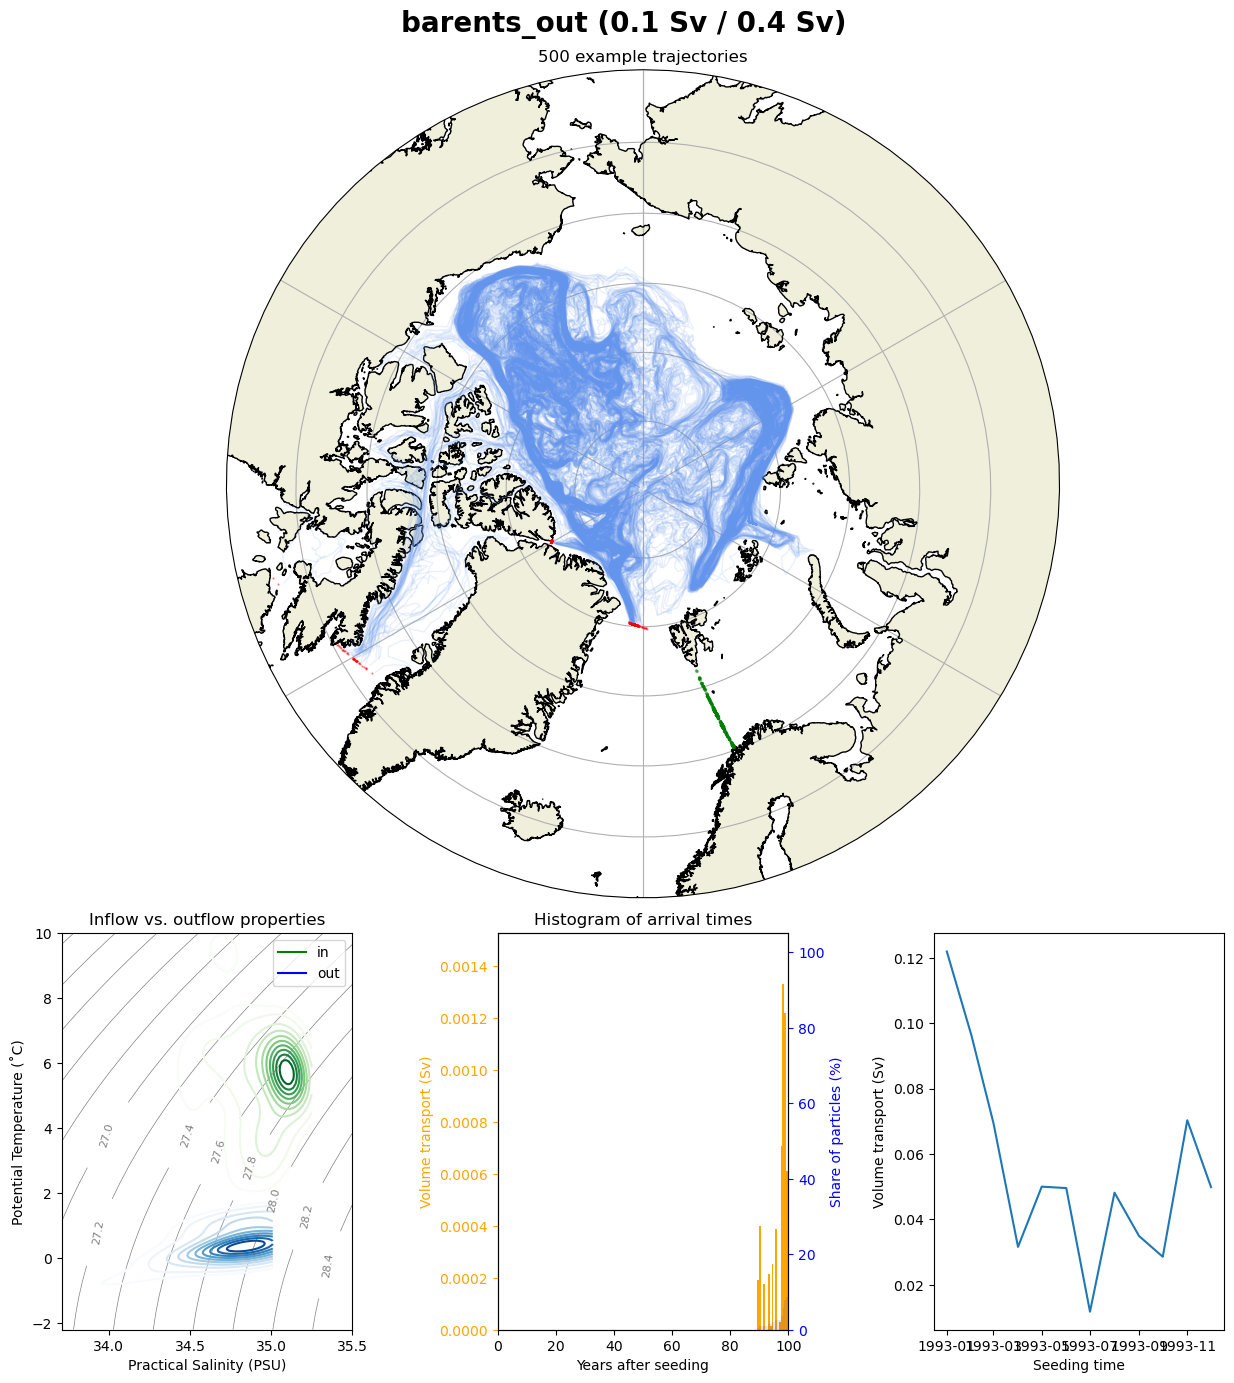

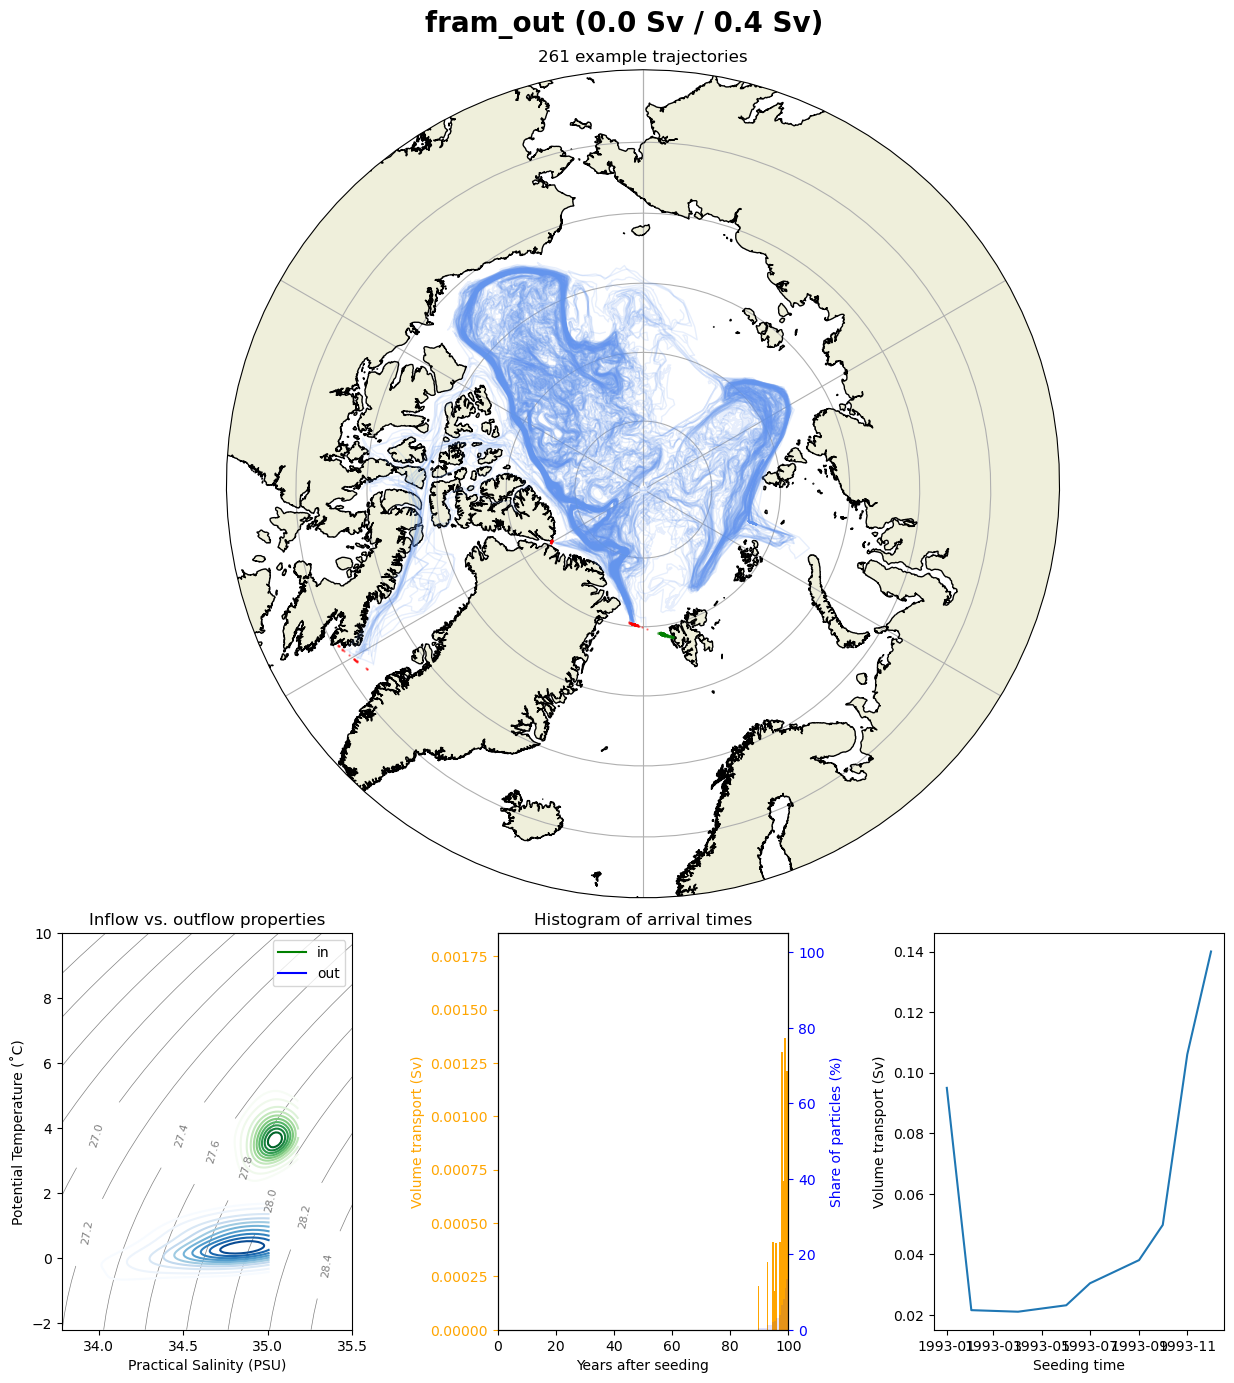

In [28]:

from lagrangian import * 
import matplotlib.pyplot as plt
import lt_toolbox as ltt
import polars as pl
import numpy as np
from netCDF4 import Dataset as ds
from netCDF4 import num2date
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
from datetime import datetime as dt
import matplotlib.path as mpath
from numpy.random import randint as ri
from lagrangian import read_tracmass, read_tracmass_parallel
from copy import deepcopy as copy
import pandas as pd
import cmocean
import glob
from scipy.stats import gaussian_kde
import gsw
import seawater 
import cartopy.feature as cfeature

def sanitize_lons(lons):
    new_list = []
    oldval = 0
    treshold = 100  # used to compare adjacent longitudes
    for ix,ea in enumerate(lons):
        diff = oldval - ea
        if (ix>0):
            if (diff>treshold):
                ea = ea + 360
            elif (diff < -treshold):
                ea = ea - 360
        oldval = ea
        new_list.append(ea)
    return new_list


project = 'GLORYS12_native'
#project = 'NEMO'
case = 'Atlantic_gates_1year'
#case = 'AW_60N_Lomonosov'
fname = '19930101'
n_files = 10*12
w_file = 0
w_int = [None,None]#[6*12,10*12]
#fname2 = 'output'
#case = 'Nordic10'
#fname = '1998'
N = 500
bin_res = 0.2
vmax=1000*n_files
save = True

##################################
start_time = fname[0:4]+'-'+fname[4:6]+'-'+fname[6:8]
t_out = read_tracmass_parallel(project,case,oname=fname,ext='out')
t_ini = read_tracmass_parallel(project,case,oname=fname,ext='ini')
#t_run = read_tracmass_parallel(project,case,oname=fname,ext='run',n_files = n_files,w_file=w_file,wint=w_int)
t_err = read_tracmass_parallel(project,case,oname=fname,ext='err')
t_run = read_tracmass(project,case,oname='output_'+fname,ext='run')
print('read')


# Filter out data by killing zone
# figure out if time runs forwards or backwards
nff = 1
if np.nanmax(t_out.data['raw_time'].explode().to_numpy()) <= 0:
    nff = -1
    print('Time is running backwards...')
    
    
# Filter ini and out particles to actually include run particles
# Filter ini and out data by density constraint
t_ini.data = (t_ini.data.filter(pl.col('id').is_in(t_run.data['id']))
              .filter(pl.col('dens').explode() < 27.9)
              #.filter(pl.col('depth').explode() < 1500)
              #.filter(~pl.col('id').is_in(t_err.data['id']))
             )
t_out.data = (t_out.data.filter(pl.col('id').is_in(t_run.data['id']))
              #.filter(pl.col('dens').explode() > 27.9)
             )
t_out.data = (t_out.data.filter(pl.col('id').is_in(t_ini.data['id'])))
#t_ini.data = (t_ini.data.filter(pl.col('id').is_in(t_out.data['id'])))

# get the number of ini time steps
n_step = len(np.unique(t_ini.data['time'].explode()))
print('Data has ',n_step,' seeding time steps')

# Define different categories of particles
T = {}
T['id_out'] = (t_out.data
                           #.filter(pl.col('lon').explode() < -20)
                           #.filter(pl.col('lat').explode() > 75) 
             )['id']

T['id_inside'] = (t_ini.data.filter(~pl.col('id').is_in(t_out.data['id']))
                             .filter(~pl.col('id').is_in(t_err.data['id']))
                                    )['id']
T['id_err'] = (t_err).data['id']
x_bar = [10,10,30,30,10]
y_bar = [65,78,78,65,65]

x_fram = [-20,-20,15,15,-20]
y_fram = [78,85,85,78,78]

T['id_barents_out'] = (t_ini.filter(pl.col('id').is_in(T['id_out']))
                       .filter_polygon(xy_vars=['lon','lat'], 
                                           x_poly=x_bar, y_poly=y_bar, 
                                           drop=False).data#['id']
                    )['id']
T['id_fram_tmp'] = (t_ini#.filter(pl.col('id').is_in(T['id_n_AW']))
                    .filter_polygon(xy_vars=['lon','lat'], 
                                           x_poly=x_fram, y_poly=y_fram, 
                                           drop=False).data#['id']
                  )['id']

T['id_fram_out'] = (t_out.data.filter(pl.col('id').is_in(T['id_out']))
                .filter(pl.col('id').is_in(T['id_fram_tmp']))
                  .filter(~pl.col('id').is_in(T['id_barents_out'])))['id']


T.pop('id_fram_tmp')
zones = [t.split('id_')[1] for t in T]

#zones = ['inside','err']
print(zones)


all_prob = t_run.compute_probability(bin_res = bin_res,prob_type='traj').summary_data

plt.figure(figsize=(10,10))
ax = plt.subplot(1,1,1,projection=ccrs.NorthPolarStereo())
plt.pcolormesh(all_prob.lon,all_prob.lat,all_prob.probability * len(t_run),
               transform= ccrs.PlateCarree(),vmin=5,vmax=vmax,cmap='Oranges',norm='log')
plt.colorbar(orientation='horizontal',aspect=50,label='Number of particles',pad=0.05,shrink=0.7)
ax.coastlines(resolution='10m',zorder=9)
ax.gridlines()
ax.add_feature(cfeature.LAND)
polarCentral_set_latlim([60,90], ax)
plt.title(project+' '+case+': All particles')
if save:
    plt.savefig('/home/jdo043/plots/ArMOC/Lagrangian/'+project+'_'+case+'_'+fname+'_density.png',dpi=300)

########### LOOP OVER ZONES #################
for zone in zones:
    if len(T['id_'+zone]) == 0:
        continue
    print('--- Doing '+zone)
    T['T_'+zone] = copy(t_run).filter(pl.col('id').is_in(T['id_'+zone]))
    T['T_in_'+zone] = copy(t_ini).filter(pl.col('id').is_in(T['id_'+zone]))
    T['T_out_'+zone] = copy(t_out).filter(pl.col('id').is_in(T['id_'+zone]))
    
    #vt_all = np.round(np.nansum(T['T_'+zone].data['vt'])/1e6/n_step,1)[0]
    a = T['T_'+zone].data.sample(n=min(N,len(T['T_'+zone]))).sort('id')
    a_ini = T['T_in_'+zone].data.filter(pl.col('id').is_in(a['id'])).sort('id')
    a_out = T['T_out_'+zone].data.filter(pl.col('id').is_in(a['id'])).sort('id')
    
    print(len(T['T_'+zone]),'/',len(t_run),'particles')

    plt.figure(figsize=(15,15))
    dates = list(np.linspace(np.min(t_ini.data['raw_time'].to_numpy())[0],
                             np.max(t_out.data['raw_time'].to_numpy())[0],100))
    if nff == -1:
        dates = list(np.linspace(np.min(t_out.data['raw_time'].to_numpy())[0],
                             np.max(t_ini.data['raw_time'].to_numpy())[0],100))
    
    
    # Pick n_part random particles
    ax = plt.subplot(3,1,(1,2),projection=ccrs.NorthPolarStereo())
    for i in range(len(a)):
        llon = a[i]['lon'][0]
        llon[llon == 0] = np.nan
        ax.plot(sanitize_lons(llon),a[i]['lat'][0],
               transform= ccrs.Geodetic(),
                alpha=1 / (np.log(len(a)) + 1) ,lw=1,zorder=10,color='cornflowerblue')
        try:
            if zone in ['inside','err']:
                ax.scatter(a[i]['lon'][0][-1],a[i]['lat'][0][-1],
                   transform= ccrs.PlateCarree(), marker='.',
                    alpha=1 / (np.log(len(a))/4 + 1) ,s=2,zorder=10,color='red')
                
            ax.scatter(a_ini[i]['lon'][0][0],a_ini[i]['lat'][0][0],
                   transform= ccrs.PlateCarree(), marker='x',
                    alpha=1 / (np.log(len(a))/4 + 1) ,s=2,zorder=10,color='green')
            ax.scatter(a_out[i]['lon'][0][0],a_out[i]['lat'][0][0],
                   transform= ccrs.PlateCarree(), marker='.',
                    alpha=1 / (np.log(len(a))/4 + 1) ,s=2,zorder=10,color='red')
        except:
            pass
    ax.coastlines(resolution='10m',zorder=9)
    ax.gridlines()
    ax.add_feature(cfeature.LAND)
    polarCentral_set_latlim([60,90], ax)
    plt.title(str(len(a))+' example trajectories')

    vt_z = np.round(np.nansum(T['T_in_'+zone].data['vt'])/1e6/n_step,1)[0]
    vt_a = np.round(np.nansum(t_ini.data['vt'])/1e6/n_step,1)[0]
    
    plt.suptitle(zone+' ('+str(vt_z)+' Sv / '+str(vt_a)+' Sv)',fontsize=20,fontweight='bold',y=0.99)
    
    print(vt_z,'Sv /',vt_a,'Sv')
    
    ctrs = np.arange(0.1,1.1,0.1)
    # Define bin breaks:
    bin_y = np.linspace(25, 35.5+bin_res, 100).tolist()
    bin_x = np.linspace(-2, 10+bin_res, 100).tolist()
    bin_breaks = [bin_x, bin_y]
    cmaps = {'in':'Greens','out':'Blues'}
    clrs = {'in':'green','out':'blue'}
    i = 1
    s_min = 35
    for d in ['in','out']:
        try:
            ax = plt.subplot(3,3,7)
            TS = T['T_'+d+'_'+zone].compute_binned_statistic_2d('temp', 'salt', values='depth', 
                                                     statistic='count', bin_breaks=bin_breaks, 
                                                                 alias='ts').summary_data
            #plt.contourf(TS.salt,TS.temp,TS['ts']/len(T['T_'+d+'_'+zone]),
            #            levels=ctrs,cmap=cmaps[d],extend='max')

            x = T['T_'+d+'_'+zone].data['salt'].explode().to_numpy()
            y = T['T_'+d+'_'+zone].data['temp'].explode().to_numpy()
            xmin,xmax = np.nanpercentile(x,1)-0.3, np.nanpercentile(x,99)+0.1
            ymin,ymax = -2, np.nanpercentile(y,99)+0.3
            k = gaussian_kde(np.vstack([x,y]))
            xi, yi = np.mgrid[xmin:xmax:100*1j,ymin:ymax:100*1j]
            zi = k(np.vstack([xi.flatten(), yi.flatten()]))


            #set zi to 0-1 scale
            zi = (zi-zi.min())/(zi.max() - zi.min())
            zi =zi.reshape(xi.shape)


            #set up plot
            origin = 'lower'
            levels = [0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]

            if d == 'in':
                tt = np.arange(-2.2,11,0.5)
                ss = np.arange(30,36,0.5)
                tt,ss = np.meshgrid(tt,ss)
                llevels = np.arange(23,28.6,0.2)
                ccs = ax.contour(ss,tt,seawater.dens0(ss,tt)-1000,levels=llevels,colors='grey',linewidths=0.5)
                ax.clabel(ccs,fmt = '%1.1f',fontsize=8,inline_spacing=15)

            CS = ax.contour(xi, yi, zi,levels = levels,
                          cmap=cmaps[d],
                          origin=origin)


            s_min = min(np.nanpercentile(x,10),s_min)
            ax.set_xlim(s_min-0.2,35.5)
            ax.set_ylim(-2.2,10)
            
            #
            #ax.set_xlim(34.8,35.)
            #ax.set_ylim(-2.2,1)
            #
            ax.set_xlabel('Practical Salinity (PSU)')
            ax.set_ylabel('Potential Temperature (˚C)')
            ax.plot([],[],color=clrs[d],label=d)
            i += 1
            if d == 'out':
                plt.legend()
                plt.title('Inflow vs. outflow properties')
            
                
        except Exception as e:
            print(e)
            pass  
    if len(T['T_out_'+zone]) == len(T['T_in_'+zone]):
        tin = T['T_in_'+zone].data.sort('id')
        tout = T['T_out_'+zone].data.sort('id')
        ax = plt.subplot(3,3,8)
        _,b,_ = ax.hist([nff*t.total_seconds() / (365.25*24*60*60) for t in tout['time'].explode() - tin['time'].explode()],
                bins=100,weights=T['T_out_'+zone].data['vt'].explode()/ 1e6 / n_step,cumulative=False,color='orange')
        ax.set_ylabel('Volume transport (Sv)',color='orange')
        ax.tick_params(axis='y', colors='orange')
        #ax2 = plt.twinx()
        #ax2.hist([nff*t.total_seconds() / 31536000 for t in T['T_out_'+zone].data['time'].explode() - T['T_in_'+zone].data['time'].explode()],
        #        bins=100,weights=T['T_out_'+zone].data['vt'].explode()/ 1e6,cumulative=True,histtype=u'step')
        ax3 = ax.twinx()
        ax3.hist([nff*t.total_seconds() / 31536000 for t in tout['time'].explode() - tin['time'].explode()],
                bins=100,color='blue',weights = np.ones(len(T['T_out_'+zone]))/len(T['T_out_'+zone])*100,cumulative=True,alpha=0.1)#histtype=u'step')
        ax3.yaxis.label.set_color('blue');ax3.tick_params(axis='y', colors='blue')
        ax3.set_ylabel('Share of particles (%)')
        plt.title('Histogram of arrival times')
        ax.set_xlabel('Years after seeding')
        #ax.set_ylim(0,0.4*ax.get_ylim()[1])
        ax.set_xlim(0,100)#max(b))

    # Plot timeseries of Volume transport by seeding date
    ax = plt.subplot(3,3,9)
    tlevels = np.unique(T['T_in_'+zone].data['time'].explode())

    trans_lev = []
    for tl in tlevels:
        trans_lev.append(np.nansum(T['T_in_'+zone].filter(pl.col('time').explode() == tl).data['vt'])/1e6)
    plt.plot(tlevels,trans_lev)
    plt.xlabel('Seeding time')
    plt.ylabel('Volume transport (Sv)')
    
    plt.subplots_adjust(hspace=0.09,wspace=0.5,top=0.95)
    if save:
        plt.savefig('/home/jdo043/plots/ArMOC/Lagrangian/'+project+'_'+case+'_'+fname+'_'+zone+'_overview.png',dpi=300)

## Plot example density trajectories

Reading split_19950101_1995_01_01 ...
Reading split_19950101_1995_02_01 ...
Reading split_19950101_1995_03_01 ...
Reading split_19950101_1995_04_01 ...
Reading split_19950101_1995_05_01 ...
Reading split_19950101_1995_06_01 ...
Reading split_19950101_1995_07_01 ...
Reading split_19950101_1995_08_01 ...
Reading split_19950101_1995_09_01 ...
Reading split_19950101_1995_10_01 ...
Reading split_19950101_1995_11_01 ...
Reading split_19950101_1995_12_01 ...
Concatenating...
read
Data has  12  seeding time steps
['out', 'barents_out', 'fram_out']
--- Doing out
81857 / 105508 particles
--- Doing barents_out
31987 / 105508 particles
--- Doing fram_out
49870 / 105508 particles


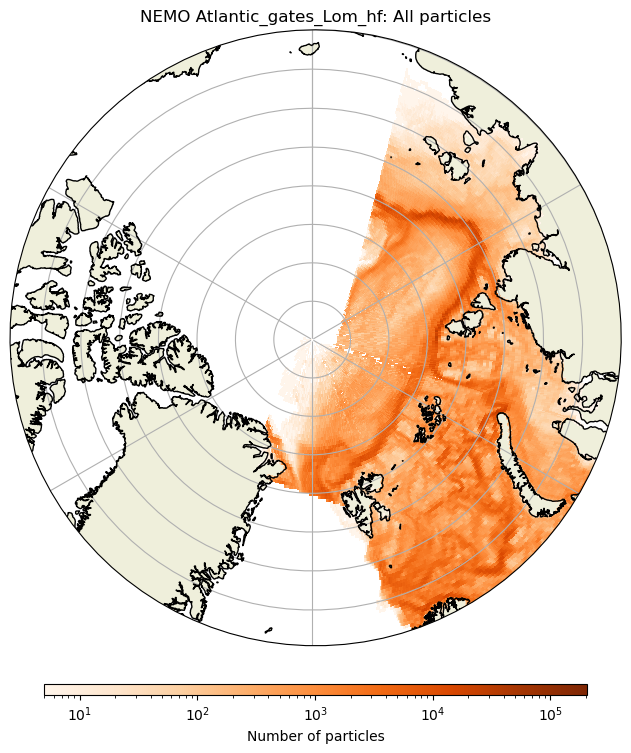

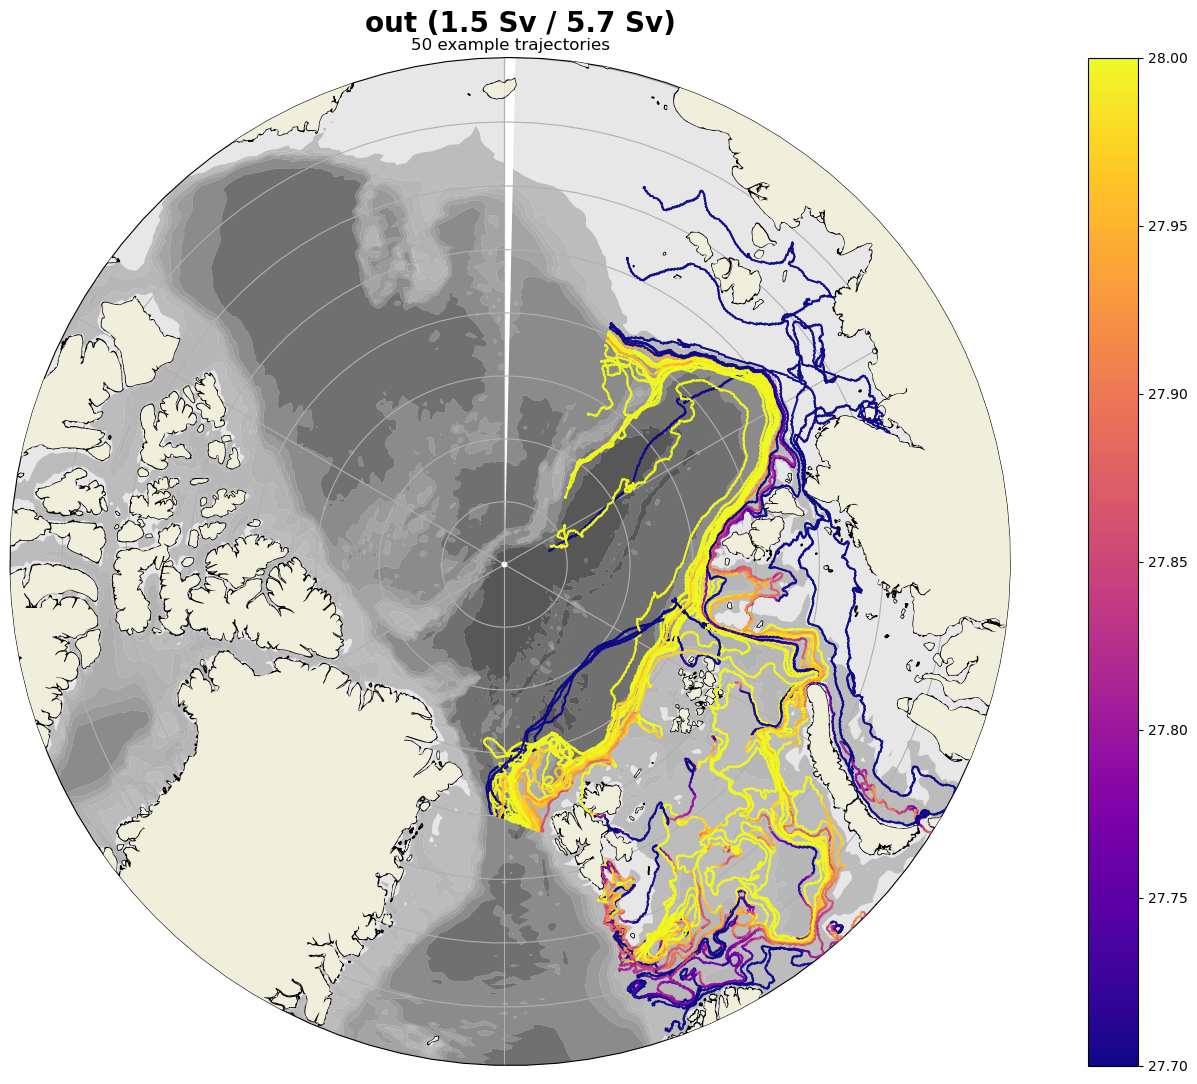

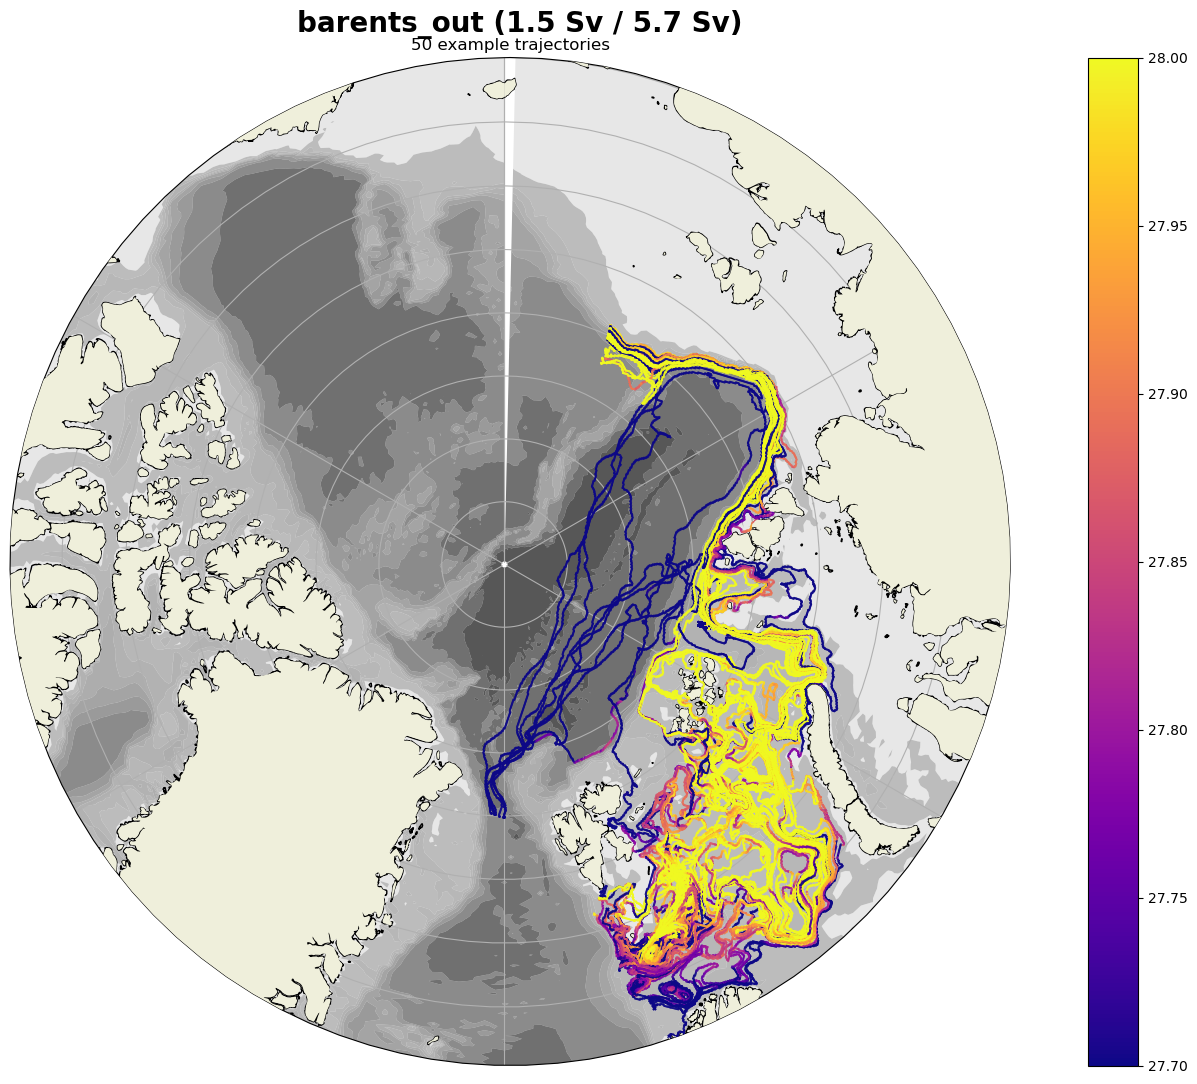

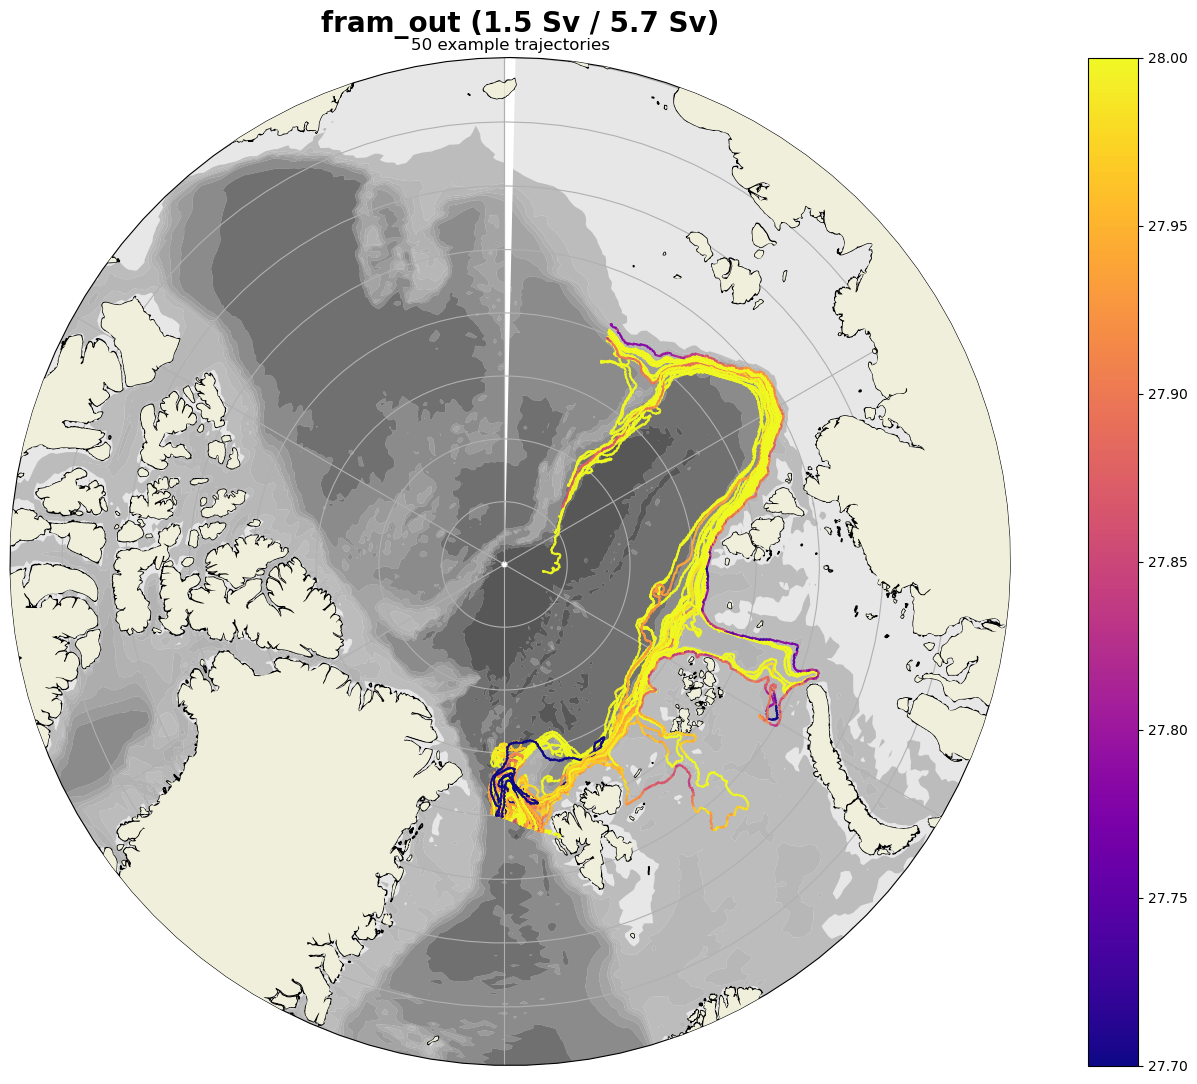

In [108]:

from lagrangian import * 
import matplotlib.pyplot as plt
import lt_toolbox as ltt
import polars as pl
import numpy as np
from netCDF4 import Dataset as ds
from netCDF4 import num2date
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
from datetime import datetime as dt
import matplotlib.path as mpath
from numpy.random import randint as ri
from lagrangian import read_tracmass, read_tracmass_parallel
from copy import deepcopy as copy
import pandas as pd
import cmocean
import glob
from scipy.stats import gaussian_kde
import gsw
import seawater 
import cartopy.feature as cfeature
from scipy.interpolate import interp1d as ip
def sanitize_lons(lons):
    new_list = []
    oldval = 0
    treshold = 100  # used to compare adjacent longitudes
    for ix,ea in enumerate(lons):
        diff = oldval - ea
        if (ix>0):
            if (diff>treshold):
                ea = ea + 360
            elif (diff < -treshold):
                ea = ea - 360
        oldval = ea
        new_list.append(ea)
    return new_list


project = 'GLORYS12_native'
project = 'NEMO'
case = 'Atlantic_gates_Lom_hf'
#case = 'AW_60N_Lomonosov'
fname = '19950101'
n_files = 17*12
w_file = 0
w_int = [None,None]#[6*12,10*12]
#fname2 = 'output'
#case = 'Nordic10'
#fname = '1998'
N = 50
bin_res = 0.2
vmax=1000*n_files
save = True
s_moc = 27.5
e_s = 70
##################################
start_time = fname[0:4]+'-'+fname[4:6]+'-'+fname[6:8]
t_out = read_tracmass_parallel(project,case,oname=fname,ext='out')
t_ini = read_tracmass_parallel(project,case,oname=fname,ext='ini')
t_run = read_tracmass_parallel(project,case,oname=fname,ext='run',n_files = n_files,w_file=w_file,wint=w_int)
#t_err = read_tracmass_parallel(project,case,oname=fname,ext='err')
#t_run = read_tracmass(project,case,oname='output_'+fname,ext='run')
print('read')


# Filter out data by killing zone
# figure out if time runs forwards or backwards
nff = 1
if np.nanmax(t_out.data['raw_time'].explode().to_numpy()) <= 0:
    nff = -1
    print('Time is running backwards...')
    
    
# Filter ini and out particles to actually include run particles
# Filter ini and out data by density constraint
t_ini.data = (t_ini.data.filter(pl.col('id').is_in(t_run.data['id']))
              .filter(pl.col('dens').explode() > s_moc)
              #.filter(pl.col('depth').explode() < 1500)
              #.filter(~pl.col('id').is_in(t_err.data['id']))
             )
t_out.data = (t_out.data.filter(pl.col('id').is_in(t_run.data['id']))
              #.filter(pl.col('dens').explode() < s_moc)
             )
t_out.data = (t_out.data.filter(pl.col('id').is_in(t_ini.data['id'])))
#t_ini.data = (t_ini.data.filter(pl.col('id').is_in(t_out.data['id'])))

# get the number of ini time steps
n_step = len(np.unique(t_ini.data['time'].explode()))
print('Data has ',n_step,' seeding time steps')

# Define different categories of particles
T = {}
T['id_out'] = (t_out.data
                           #.filter(pl.col('lon').explode() < -20)
                           #.filter(pl.col('lat').explode() > 75) 
             )['id']

#T['id_inside'] = (t_ini.data.filter(~pl.col('id').is_in(t_out.data['id']))
#                            # .filter(~pl.col('id').is_in(t_err.data['id']))
#                                    )['id']
#T['id_err'] = (t_err).data['id']
x_bar = [10,10,30,30,10]
y_bar = [65,78,78,65,65]

x_fram = [-20,-20,15,15,-20]
y_fram = [78,85,85,78,78]

T['id_barents_out'] = (t_ini.filter(pl.col('id').is_in(T['id_out']))
                       .filter_polygon(xy_vars=['lon','lat'], 
                                           x_poly=x_bar, y_poly=y_bar, 
                                           drop=False).data#['id']
                    )['id']
T['id_fram_tmp'] = (t_ini#.filter(pl.col('id').is_in(T['id_n_AW']))
                    .filter_polygon(xy_vars=['lon','lat'], 
                                           x_poly=x_fram, y_poly=y_fram, 
                                           drop=False).data#['id']
                  )['id']

T['id_fram_out'] = (t_out.data.filter(pl.col('id').is_in(T['id_out']))
                .filter(pl.col('id').is_in(T['id_fram_tmp']))
                  .filter(~pl.col('id').is_in(T['id_barents_out'])))['id']


T.pop('id_fram_tmp')
zones = [t.split('id_')[1] for t in T]

#zones = ['inside','err']
print(zones)


all_prob = t_run.compute_probability(bin_res = bin_res,prob_type='traj').summary_data

plt.figure(figsize=(10,10))
ax = plt.subplot(1,1,1,projection=ccrs.NorthPolarStereo())
plt.pcolormesh(all_prob.lon,all_prob.lat,all_prob.probability * len(t_run),
               transform= ccrs.PlateCarree(),vmin=5,vmax=vmax,cmap='Oranges',norm='log')
plt.colorbar(orientation='horizontal',aspect=50,label='Number of particles',pad=0.05,shrink=0.7)
ax.coastlines(resolution='10m',zorder=9)
ax.gridlines()
ax.add_feature(cfeature.LAND)
polarCentral_set_latlim([e_s,90], ax)
plt.title(project+' '+case+': All particles')
if save:
    plt.savefig('/home/jdo043/plots/ArMOC/Lagrangian/'+project+'_'+case+'_'+fname+'_density.png',dpi=300)

########### LOOP OVER ZONES ####################################################################################
for zone in zones:
    if len(T['id_'+zone]) == 0:
        continue
    print('--- Doing '+zone)
    T['T_'+zone] = copy(t_run).filter(pl.col('id').is_in(T['id_'+zone]))
    T['T_in_'+zone] = copy(t_ini).filter(pl.col('id').is_in(T['id_'+zone]))
    T['T_out_'+zone] = copy(t_out).filter(pl.col('id').is_in(T['id_'+zone]))
    
    #vt_all = np.round(np.nansum(T['T_'+zone].data['vt'])/1e6/n_step,1)[0]
    a = T['T_'+zone].data.sample(n=min(N,len(T['T_'+zone]))).sort('id')
    a_ini = T['T_in_'+zone].data.filter(pl.col('id').is_in(a['id'])).sort('id')
    a_out = T['T_out_'+zone].data.filter(pl.col('id').is_in(a['id'])).sort('id')
    
    print(len(T['T_'+zone]),'/',len(t_run),'particles')

    plt.figure(figsize=(20,12))
    dates = list(np.linspace(np.min(t_ini.data['raw_time'].to_numpy())[0],
                             np.max(t_out.data['raw_time'].to_numpy())[0],100))
    if nff == -1:
        dates = list(np.linspace(np.min(t_out.data['raw_time'].to_numpy())[0],
                             np.max(t_ini.data['raw_time'].to_numpy())[0],100))
    
    
    # Pick n_part random particles
    ax = plt.subplot(1,1,1,projection=ccrs.NorthPolarStereo())
    ibcao = xr.open_dataset('~/DATA/ArMOC/ibcao_latlon_c.nc')
    plt.contourf(ibcao.lon,ibcao.lat,-ibcao.elevation,
            levels = [-4000,100,300,500,750,1000,1500,2000,3000,4000,5000], extend='both',
            cmap='Greys',transform= ccrs.PlateCarree(),alpha=0.7,antialiased=True)


    for i in range(len(a)):
        if True:#np.nanmax(a[i]['dens'][0]) > s_moc and a[i]['dens'][0][-1] > s_moc:
            llon = a[i]['lon'][0]
            llon[llon == 0] = np.nan
            x = copy(a[i]['raw_time'][0])
            x_n = x
            lon = ip(x,a[i]['lon'][0])(x_n)
            lat = ip(x,a[i]['lat'][0])(x_n)
            dens = ip(x,a[i]['dens'][0])(x_n)
            #ax.plot(sanitize_lons(lon),lat, transform= ccrs.Geodetic(),
            #        color='k',zorder=9, lw=0.3)
            c = ax.scatter(sanitize_lons(lon),lat,c = dens,
                   transform= ccrs.Geodetic(), vmin= 27.7,vmax = 28,cmap = 'plasma', s = 1
                 ,zorder=10,marker='.')
            try:
                if zone in ['inside','err']:
                    ax.scatter(a[i]['lon'][0][-1],a[i]['lat'][0][-1],
                       transform= ccrs.PlateCarree(), marker='.',
                        alpha=1 / (np.log(len(a))/4 + 1) ,s=2,zorder=10,color='red',linestyle='-')

                ax.scatter(a_ini[i]['lon'][0][0],a_ini[i]['lat'][0][0],
                       transform= ccrs.PlateCarree(), marker='x',
                        s=5,zorder=10,c = a_ini[i]['dens'][0][0],
                          vmin= 27.7,vmax = 28,cmap = 'plasma')
                ax.scatter(a_out[i]['lon'][0][0],a_out[i]['lat'][0][0],
                       transform= ccrs.PlateCarree(), marker='.',
                        s=5,zorder=10,c = a_out[i]['dens'][0][0],
                          vmin= 27.7,vmax = 28,cmap = 'plasma')
            except:
                pass
        
    plt.colorbar(c)
    ax.coastlines(resolution='10m',zorder=9)
    ax.gridlines()
    ax.add_feature(cfeature.LAND,zorder=11)
    polarCentral_set_latlim([e_s,90], ax)
    plt.title(str(len(a))+' example trajectories')


    plt.suptitle(zone+' ('+str(vt_z)+' Sv / '+str(vt_a)+' Sv)',fontsize=20,fontweight='bold',y=0.99)
    plt.subplots_adjust(hspace=0.09,wspace=0.5,top=0.95)
    if save:
        plt.savefig('/home/jdo043/plots/ArMOC/Lagrangian/'+project+'_'+case+'_'+fname+'_'+zone+'_overview.png',
                    dpi=300)

## Calculate lagrangian overturning function in density space

read
Data has  12  seeding time steps
['out', 'barents_out', 'fram_out']
--- Doing out
104291 / 104291 particles
14.8 Sv / 14.8 Sv


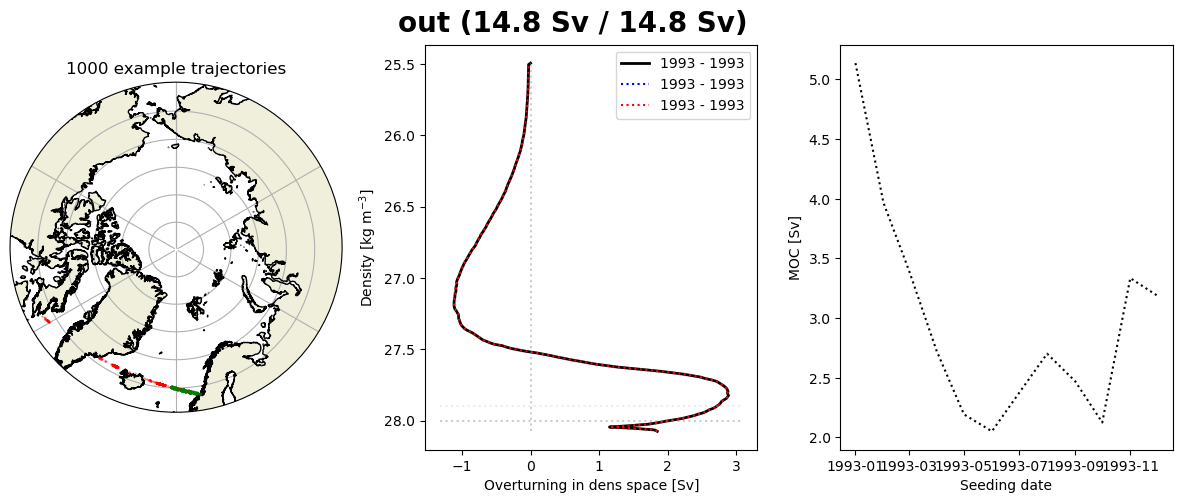

In [58]:

from lagrangian import * 
import matplotlib.pyplot as plt
import lt_toolbox as ltt
import polars as pl
import numpy as np
from netCDF4 import Dataset as ds
from netCDF4 import num2date
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
from datetime import datetime as dt
import matplotlib.path as mpath
from numpy.random import randint as ri
from lagrangian import read_tracmass, read_tracmass_parallel
from copy import deepcopy as copy
import pandas as pd
import cmocean
import glob
from scipy.stats import gaussian_kde
import gsw
import seawater 
import cartopy.feature as cfeature

def sanitize_lons(lons):
    new_list = []
    oldval = 0
    treshold = 100  # used to compare adjacent longitudes
    for ix,ea in enumerate(lons):
        diff = oldval - ea
        if (ix>0):
            if (diff>treshold):
                ea = ea + 360
            elif (diff < -treshold):
                ea = ea - 360
        oldval = ea
        new_list.append(ea)
    return new_list


project = 'GLORYS12_native'
project = 'NEMO'
case = 'Atlantic_gates_1year'
case = 'AW_60N'
fname = '19930101'
n_files = 20*12
w_file = 0
w_int = [None,None]#[6*12,10*12]
#fname2 = 'output'
#case = 'Nordic10'
#fname = '1998'
N = 1000
bin_res = 0.2
vmax=1000*n_files
save = True
n_year = 0
lof_var = 'dens'
##################################
start_time = fname[0:4]+'-'+fname[4:6]+'-'+fname[6:8]
t_out = read_tracmass_parallel(project,case,oname=fname,ext='out')
t_ini = read_tracmass_parallel(project,case,oname=fname,ext='ini')

print('read')

# get the number of ini time steps
steps = np.unique(t_ini.data['raw_time'].explode())

# Filter by steps
#t_ini.data = (t_ini.data
#            .filter(pl.col('raw_time').explode().is_in(steps[11:12])))

n_step = len(np.unique(t_ini.data['time'].explode()))
print('Data has ',n_step,' seeding time steps')


# Filter ini and out particles to actually include run particles

t_out.data = (t_out.data.filter(pl.col('id').is_in(t_ini.data['id']))
             #.filter(pl.col('depth').explode() < 500)
             )
t_ini.data = (t_ini.data
              #.filter(pl.col('id').is_in(t_out.data['id']))
             #.filter(pl.col('depth').explode() < 1500)
             )
t_out.data = (t_out.data.filter(pl.col('id').is_in(t_ini.data['id'])))
t_ini.data = (t_ini.data.filter(pl.col('id').is_in(t_out.data['id'])))

#display(t_ini.data.sort('id'))
#display(t_out.data.sort('id'))
# Define different categories of particles
T = {}
T['id_out'] = (t_out.data
                           #.filter(pl.col('lon').explode() > -45)
                           #.filter(pl.col('lon').explode() > -20)
                           #.filter((pl.col('lat').explode() > 82) | (pl.col('lon').explode() > 100))
                           #.filter((pl.col('lat').explode() < 82) & (pl.col('lon').explode() < 100))
             )['id']

#T['id_inside'] = (t_ini).data.filter(~pl.col('id').is_in(t_out.data['id']))['id']

x_bar = [10,10,30,30,10]
y_bar = [65,78,78,65,65]

x_fram = [-20,-20,15,15,-20]
y_fram = [78,85,85,78,78]

T['id_barents_out'] = (t_ini.filter(pl.col('id').is_in(T['id_out']))
                       .filter_polygon(xy_vars=['lon','lat'], 
                                           x_poly=x_bar, y_poly=y_bar, 
                                           drop=False).data#['id']
                    )['id']
T['id_fram_tmp'] = (t_ini#.filter(pl.col('id').is_in(T['id_n_AW']))
                    .filter_polygon(xy_vars=['lon','lat'], 
                                           x_poly=x_fram, y_poly=y_fram, 
                                           drop=False).data#['id']
                  )['id']

T['id_fram_out'] = (t_out.data.filter(pl.col('id').is_in(T['id_out']))
                .filter(pl.col('id').is_in(T['id_fram_tmp']))
                  .filter(~pl.col('id').is_in(T['id_barents_out'])))['id']


T.pop('id_fram_tmp')
zones = [t.split('id_')[1] for t in T]
print(zones)

toto = {}
########### LOOP OVER ZONES #################
for zone in zones:
    if len(T['id_'+zone]) == 0:
        continue
    print('--- Doing '+zone)
    
    T['T_in_'+zone] = copy(t_ini).filter(pl.col('id').is_in(T['id_'+zone]))
    T['T_out_'+zone] = copy(t_out).filter(pl.col('id').is_in(T['id_'+zone]))
    a_ini = T['T_in_'+zone].data.sample(n=min(N,len(T['T_in_'+zone]))).sort('id')
    a_out = T['T_out_'+zone].data.filter(pl.col('id').is_in(a_ini['id'])).sort('id')
    
    print(len(T['T_in_'+zone]),'/',len(t_ini),'particles')

    plt.figure(figsize=(15,5))
    
    # Pick n_part random particles
    ax = plt.subplot(1,3,1,projection=ccrs.NorthPolarStereo())
    for i in range(len(a_ini)):
        ax.scatter(a_ini[i]['lon'][0][0],a_ini[i]['lat'][0][0],
               transform= ccrs.PlateCarree(), marker='x',
                alpha=1 / (np.log(len(a_ini))/4 + 1) ,s=2,zorder=10,color='green')
        ax.scatter(a_out[i]['lon'][0][0],a_out[i]['lat'][0][0],
               transform= ccrs.PlateCarree(), marker='.',
                alpha=1 / (np.log(len(a_ini))/4 + 1) ,s=2,zorder=10,color='red')
    ax.coastlines(resolution='10m',zorder=9)
    ax.gridlines()
    ax.add_feature(cfeature.LAND)
    polarCentral_set_latlim([60,90], ax)
    plt.title(str(len(a_ini))+' example trajectories')

    vt_z = np.round(np.nansum(T['T_in_'+zone].data['vt'])/1e6/n_step,1)[0]
    vt_a = np.round(np.nansum(t_ini.data['vt'])/1e6/n_step,1)[0]
    plt.suptitle(zone+' ('+str(vt_z)+' Sv / '+str(vt_a)+' Sv)',fontsize=20,fontweight='bold',y=0.99)
    
    print(vt_z,'Sv /',vt_a,'Sv')
    
    if lof_var == 'dens':
        bin_sigma0 = np.arange(25.5, 28.25, 0.01).tolist()
    elif lof_var == 'depth':
        bin_sigma0 = np.arange(0, 500, 50).tolist() + np.arange(500, 4000, 100).tolist()
    elif lof_var == 'temp':
        bin_sigma0 = np.arange(-2, 10, 0.02).tolist()
    else:
        bin_sigma0 = np.arange(30, 35.5, 0.01).tolist()
    tt = copy(T['T_in_'+zone])
    #tt.data = tt.data.sort('id')

    tt = tt.add_variable(name=lof_var+'_in',values=(tt.data[lof_var].explode()-0.01).to_list())
    tt = tt.add_variable(name='vol',values=(tt.data['vt'].explode()).to_list())
    tt = tt.add_variable(name='start_date',values=tt.data['time'].explode().to_list())
    tt = tt.add_variable(name=lof_var+'_out',values=T['T_out_'+zone].data.sort('id')[lof_var].explode().to_list())
    
    toto[zone] = copy(tt)
    
    tt = tt.compute_property_lof(subvol='vol', prop_in=lof_var+'_in', prop_out=lof_var+'_out', bin_breaks=bin_sigma0, alias='LOF', direction='-1', group='start_date')

    
    s = tt.summary_data
    s['LOF'] = -s.LOF
    s['start_date'] = pd.to_datetime(s.start_date)
    s['LOF_max'] = s.LOF.max(lof_var)
    ss = s.groupby('start_date.year').mean('start_date')
    plt.subplot(1,3,2)
    plt.plot((s.LOF/1e6).mean('start_date'),s[lof_var],lw=2,
            label=str(ss.year.data[0])+' - '+str(ss.year.data[-1]),color='k')
    plt.plot((s.LOF/1e6).isel(start_date=slice(0,n_year*12)).mean('start_date'),s[lof_var],
             label=str(ss.year.data[0])+' - '+str(ss.year.data[n_year]),linestyle=':',color='b')
    plt.plot((s.LOF/1e6).isel(start_date=slice(-n_year*12,None)).mean('start_date'),s[lof_var],
             label=str(ss.year.data[-n_year])+' - '+str(ss.year.data[-1]),linestyle=':',color='r')
    plt.plot(s[lof_var]*0,s[lof_var],color='grey',alpha=0.4,linestyle=':')
    xlm = plt.gca().get_xlim()
    if lof_var == 'dens':
        plt.plot(xlm,[27.9,27.9],color='lightgrey',alpha=0.4,linestyle=':')
        plt.plot(xlm,[28,28],color='grey',alpha=0.4,linestyle=':')
    plt.gca().invert_yaxis()
    plt.xlabel('Overturning in '+lof_var+' space [Sv]')
    if lof_var == 'dens':
        plt.ylabel('Density [kg m$^{-3}$]')
    else:
        plt.ylabel(lof_var)
    plt.legend()
    
    plt.subplot(1,3,3)
    plt.plot(s.start_date,np.nanmax(s.LOF.data,1)/1e6,color='k',linestyle=':')
    plt.plot([pd.to_datetime(str(y)+'-06-15') for y in ss.year.data],ss.LOF_max/1e6,color='k',linewidth=2)
    plt.ylabel('MOC [Sv]')
    plt.xlabel('Seeding date')
    plt.subplots_adjust(hspace=0.09,wspace=0.25,top=0.92)
    if save:
        plt.savefig('/home/jdo043/plots/ArMOC/Lagrangian/'+project+'_'+case+'_'+fname+'_'+zone+'_LOF.png',dpi=300)